# Jax tutorial

From the website of `jax` we quote:

**JAX is NumPy on the CPU, GPU, and TPU, with great automatic differentiation for high-performance machine learning research.**

In a nutshell, `jax` leverages the power of two packages: [XLA](https://www.tensorflow.org/xla), which allows you to compile your Python code just-in-time (`jit`) into XLA-optimized kernels that can run in either in CPU or in accelerators (such as GPUs and TPUs); and an updated version of [Autograd](https://github.com/hips/autograd), which allows `jax` to differente native Python and NumPy code. It can differentiate through loops, ifs, recursion, and closures, and it can even take derivatives of derivatives of derivatives.

`jax` also allows to compose this operations arbitrarily (under some constraints), which allows to express complex algorithms and get high-performance without leaving Python.

In this notebook, we will introduce some important features of the library `jax`.

As usual we import the libraries. We point out that `jax` has its own implementation of the numpy library (with most of the functions included). For comparison we also import the regular `numpy` library.

In [58]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

One of the biggest advantages of `jax` is the fact that it follows closely `numpy`'s syntax.

In [59]:
x1 = jnp.arange(10)
x2 = np.arange(10)
print(x1)
print(x2)

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


We note that we have to use `jnp` instead of `np`. Nevertheless, we point that the type of the object is slightly different. The `numpy` object is an `ndarray` whereas the `jax` object is an `jax.Array`. Even though they are different objects, they have the same in-memory representation, which allows to transform one to the other very efficiently.  

In [60]:
x1

DeviceArray([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [61]:
x2

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [62]:
print(f"Type of the jax Array {type(x1)}")
print(f"Type of the numpy Array {type(x2)}")

Type of the jax Array <class 'jaxlib.xla_extension.DeviceArray'>
Type of the numpy Array <class 'numpy.ndarray'>


The similar in-memory representation allows us to inper operate between jax and numpy arrays. For example we can compute the distance between them, by simple substracting them and computing the norm, whose implementation can be either the one in `numpy` or `jax`.

In [63]:
print(f"Numpy distance: {np.linalg.norm(x1 - x2)}")
print(f"Jax distance: {jnp.linalg.norm(x1 - x2)}")


Numpy distance: 0.0
Jax distance: 0.0


A minor differnce to take in consideration is the default data type. Given that `jax` was mainly developped for Machine Learning applications the defauilt types are 32-bits, instead of the 64-bits defaults in `numpy`.

In many applications is usually safe to use single precision (which renders the computations faster), however, it is possible to activate the "64-bit mode", if more accuracy is necessary. In this Tutorial however, we will use the default mode for simplicity.  

In [64]:
print(f"Type of the data jax Array {x1.dtype}")
print(f"Type of the data numpyr Array {x2.dtype}")

Type of the data jax Array int32
Type of the data numpyr Array int64


## Function transformation

One of the most prominent feature of jax is to use 'function transformation', or in another words functions (or methods) whose input/output are functions, where the input functions are tranformed following certain rules. This is very handy, for compiling, vectorizing and computing gradients.

This allows us to compose these transformations. In what follows we consider three main of these methods, `jit`, `grad` and `vmap`.  

### The `jit` transformation

The `jit`, as shorthand for just-in-time, is a transformation that takes a function written in *Python* with `jax` syntax and returns a compiled version. The compiled version leverages the poser of `XLA` to fuse operations and highly optimize it.

Let's start with a simple example which it often used in machine learning.

In [65]:
def selu(x, alpha=1.67, lambda_=1.05):
  """Computes the SeLU activation function."""
  return lambda_ * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

Not we time this function.

In [66]:
x = jnp.arange(1000000)
%timeit selu(x).block_until_ready()

8.18 ms ± 356 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


As we can see this is quite slow, particularly when such activation functions need to be used very often in ML workflows. So let's use the `jit` compiler.

In [67]:
selu_jit = jax.jit(selu)

As you can see, the `jax.jit` function, takes the `selu` function, and output a new function, which we can evaluate as before.



In [68]:
y = selu_jit(x)

We make sure that the output is the same as the original function.

In [69]:
difference = jnp.linalg.norm(selu(x) - selu_jit(x))
print(f"Difference between the normal and jitted function is {difference}")

Difference between the normal and jitted function is 0.0


In [70]:
%timeit selu_jit(x).block_until_ready()

1.61 ms ± 338 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


So, by just levering this transformation we can obtain a 3x speedup.

### The `grad` transformation

Another transformation that is frequently used is `grad`. As the name points, it takes a numerical function in *Python* and transforms it by computing its gradient. It is like using the $\nabla$ operator in the function.

In [71]:
def sum_of_squares(x):
  return jnp.sum(x**2)

In [72]:
sum_of_squares_dx = jax.grad(sum_of_squares)

x = jnp.asarray([1.0, 2.0, 3.0, 4.0])

print(sum_of_squares(x))

print(sum_of_squares_dx(x))

30.0
[2. 4. 6. 8.]


We can do the latter in one line if we want to too.

In [73]:
print(jax.grad(sum_of_squares)(x))

[2. 4. 6. 8.]


The way `jax` computes the gradient of a function makes it straightforward when our function has more than one variable. By default, `jax.grad` will compute the gradient with respect to the **first** argument.

In [74]:
def sum_squared_error(x, y):
  return jnp.sum((x-y)**2)

sum_squared_error_dx = jax.grad(sum_squared_error)

x = jnp.asarray([1.0, 2.0, 3.0, 4.0])
y = jnp.asarray([1.1, 2.1, 3.1, 4.1])

print(sum_squared_error_dx(x, y))

[-0.20000005 -0.19999981 -0.19999981 -0.19999981]


So, if we want to compute with respect to a different argument (or all of them) we need to point it out using the argument `argnums`.

In [75]:
# Compute gradient with respect to y.
jax.grad(sum_squared_error, argnums=1)(x, y)

DeviceArray([0.20000005, 0.19999981, 0.19999981, 0.19999981], dtype=float32)

In [76]:
# Compute gradient with respect to both x and y.
jax.grad(sum_squared_error, argnums=(0, 1))(x, y)

(DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
 DeviceArray([0.20000005, 0.19999981, 0.19999981, 0.19999981], dtype=float32))

Additionally, you can get at the same time the value of the function and also its gradient. We use `jax.value_and_grad` for this.

In [77]:
jax.value_and_grad(sum_squared_error)(x, y)

(DeviceArray(0.03999995, dtype=float32),
 DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32))

### Simple training loop.

Let's do a very simple regression as an application of what we have learned so far.

We sample our data such that $y(x) = w_{\text{true}}x + b_{\text{true}} + \epsilon$, where $\epsilon \sim \mathcal{N}(0,0.1)$.

We want to recover $w_{\text{true}}$ and $b_{\text{true}}$. So, our model is $\hat{y}(x;\theta) = wx + b$ with $\theta = (w,b)$ and our loss function is
$$J(x,\hat{y};\theta) = (\hat{y}(x;\theta) - y(x))^{2}.$$

We use gradient descent with fixed learning rate $\alpha = 0.1$ to recover our parameters, so, we perform the following iteration for a given set of parameters $\theta$,

$$\theta_{\text{new}} = \theta_{\text{old}} - \alpha\nabla_{\theta}(J)(x,\hat{y} ;\theta_{\text{old}}).$$

For this example we pick $w = 3$ and $b = -1$.


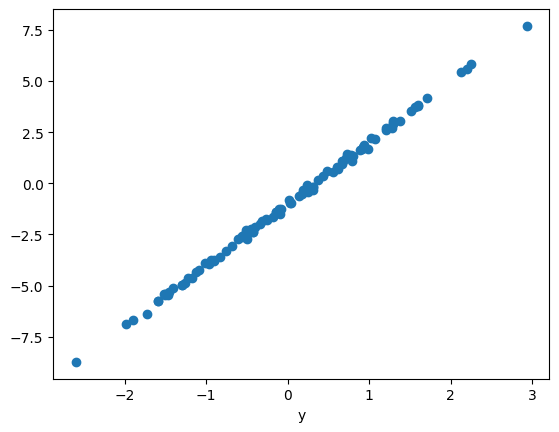

In [78]:
xs = np.random.normal(size=(100,))
noise = np.random.normal(scale=0.1, size=(100,))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys)
plt.xlabel('x')
plt.xlabel('y')
plt.show()

In [79]:
def model(theta: jax.Array, x: jax.Array) -> jax.Array:
  """Computes wx + b on a batch of input x.

  Args:
    theta: The parameters of the linear regression, w and b.
    x: The independent variable in the linear regression.

  Returns:
    The linear model applied to x.
  """
  w, b = theta
  return w * x + b


def loss_fn(theta: jax.Array, x: jax.Array, y: jax.Array) -> jax.Array:
  """Computes the MSE loss between the output of the model and the data.

  Args:
    theta: The parameters of the linear model.
    x: Independent variable.
    y: Dependent variable to fit.

  Returns:
    The MSE between the prediction of the model and the data given by the tuples
    (x, y).
  """
  prediction = model(theta, x)
  return jnp.mean((prediction-y)**2)


def update(theta: jax.Array, x:jax.Array, y:jax.Array, lr: float=0.1) -> jax.Array:
  """Computes the updates for Gradient descent."""
  return theta - lr * jax.grad(loss_fn)(theta, x, y)

We added the signatures of the inputs and outputs to could help us debug later.

Let's solve this problem, and time it to have an idea of how long it takes.

In [80]:
%%time
# Initial guess of just ones.
theta = jnp.array([1., 1.])

for i in range(1000):
  theta_old = theta
  theta = update(theta, xs, ys)
  if jnp.linalg.norm(theta_old - theta) < 1.e-7:
    print(f"Total number of iteration to convergence {i}")
    break

Total number of iteration to convergence 70
CPU times: user 629 ms, sys: 4.66 ms, total: 633 ms
Wall time: 645 ms


So it takes roughly around 66 iterations to converge and half a second of wall-time.

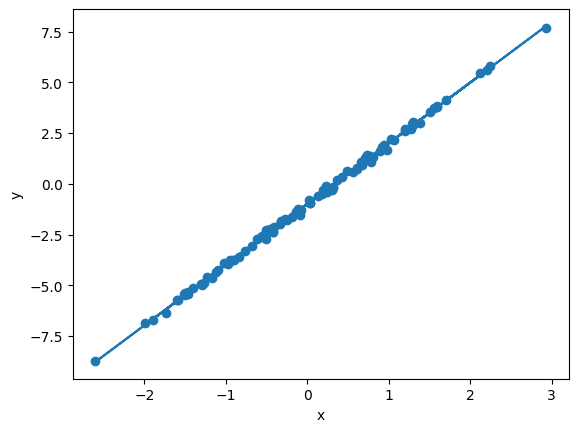

w: 2.993, b: -0.993


In [81]:
plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs))
plt.xlabel('x')
plt.ylabel('y')
plt.show()

w, b = theta
print(f"w: {w:<.3f}, b: {b:<.3f}")

Now this is quite simple, but we are not using `jax` at its full potential.
Let's time the loop over 100 steps, without the convergence checks.

In [82]:
%%timeit
theta = jnp.array([1., 1.]) # initial guess
for _ in range(100):
  theta = update(theta, xs, ys)

1.01 s ± 211 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This is indeed quite slow for so simple operations. In this regard, it is clear that the issue comes from the function inside the loop.

Now, we learned above that if the function satisfies a few conditions (i.e., it is a pure function) then we can use ```jit``` to accelerate it. So let's do that.

In this case, ```update``` has a learning rate field ```lr```, that it doesn't change so we will make it static. The syntax is given by:


In [83]:
update_jit = jax.jit(update, static_argnames = 'lr')

# trigger the jit compilation
theta = update_jit(theta, xs, ys)

Not let's time it.

In [84]:
%%timeit
theta_jit = jnp.array([1., 1.]) # initial guess
for _ in range(100):
  theta_jit = update_jit(theta_jit, xs, ys)

1.62 ms ± 525 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Depending on your computer you should have observed between a 100x-600x speed up, but just using the ```jit``` transformation. In a nutshell, the ```XLA``` compiler fuses many of the operations and avoids copies, which makes the code highly efficient for this type of problems.

### Computing Jacobians

Now, computing gradients works only when the function is scalar values. However, this can be also extended for computing the Jacobian of a vector-valued function using the transformation `jax.jaxfwd`. We don't enter into details, but you can use it to compute higher order derivatives, such as the Hessian, by composing different transformations. For example:

In [85]:
def hessian(f):
  """Transformation to compute the Hessian of f."""
  return jax.jacfwd(jax.grad(f))

In [86]:
hessian_model = hessian(loss_fn)
hessian_local = hessian_model(theta, xs, ys)

print(hessian_local)

[[2.332261   0.04255177]
 [0.04255177 2.        ]]


Now you can do even a more efficient iteration using Newton's method instead of gradient descent. In this case we will define the grad and the hessian outside the iteration function.

In [87]:
grad_loss = jax.grad(loss_fn)
hessian_loss = hessian(loss_fn)

def newton_iteration(theta: jax.Array, x:jax.Array, y: jax.Array) -> jax.Array:
  """Performs one Newton iterations.

  Args:
    theta: The parameters of the linear model.
    x: Independent variable.
    y: Dependent variable to fit.

  Returns:
    One iteration of the Netwon method,
    ϑ = ϑ - ∇^2f(ϑ)\∇f(ϑ)
  """
  grad_local = grad_loss(theta, x, y)
  hessian_local = hessian_loss(theta, x, y)
  return theta - jnp.linalg.solve(hessian_local, grad_local)

Now we can solve this problem in just one (or two) iterations.

In [88]:
%%time
theta_newton = jnp.array([1., 1.]) # initial guess
theta_newton = newton_iteration(theta_newton, xs, ys)

CPU times: user 33.9 ms, sys: 0 ns, total: 33.9 ms
Wall time: 37 ms


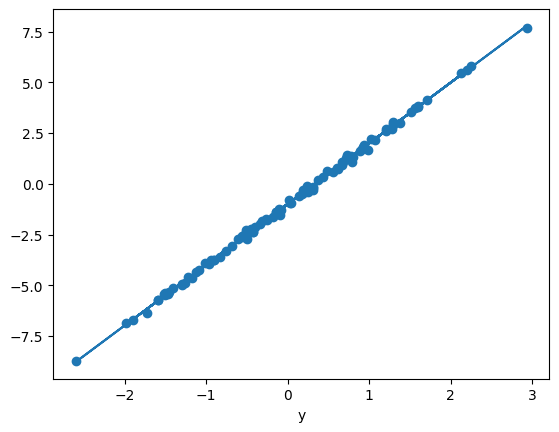

w: 2.993, b: -0.993


In [89]:
plt.scatter(xs, ys)
plt.plot(xs, model(theta_newton, xs))
plt.xlabel('x')
plt.xlabel('y')
plt.show()

w, b = theta_newton
print(f"w: {w:<.3f}, b: {b:<.3f}")

We point out, that in this case, using a highly optimized (using ```jit```) Gradient Descent iteration was the faster method, being even faster than using a Newton iteration that takes only one iteration!!!.

# Exercise 1

Resolve the same minimization problem but fitting a non-linear rational model given by

$y = f(x) := \frac{ax}{bx + c} $

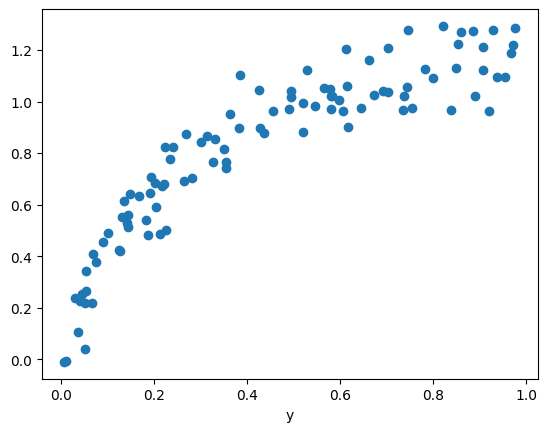

In [103]:
xs = np.random.uniform(size=(100,))
noise = np.random.normal(scale=0.1, size=(100,))
ys = xs * 3 / (xs * 2 + 0.5)  + noise

plt.scatter(xs, ys)
plt.xlabel('x')
plt.xlabel('y')
plt.show()

In [ ]:
def model_rat(theta: jax.Array, x: jax.Array) -> jax.Array:
  """Computes wx + b on a batch of input x.

  Args:
    theta: The parameters of the linear regression, w and b.
    x: The independent variable in the linear regression.

  Returns:
    The linear model applied to x.
  """
  a, b, c = theta
  return x * a / (x * b + c)


def loss_fn_rat(theta: jax.Array, x: jax.Array, y: jax.Array) -> jax.Array:
  """Computes the MSE loss between the output of the model and the data.

  Args:
    theta: The parameters of the linear model.
    x: Independent variable.
    y: Dependent variable to fit.

  Returns:
    The MSE between the prediction of the model and the data given by the tuples
    (x, y).
  """
  prediction = model_rat(theta, x)
  return jnp.mean((prediction-y)**2)

Now reuse the transformations above to solve this problem. Given that this problem is non-convex you may want initialize your guess relatively close to the correct solut

## Exercise 1b (optional)
Here we will use the tranformations introduced above to solve the same minimization problem, but using the Gauss-Newton Methods, which is much cheaper than Newton's method, given that it doesn't require to compute the Hessian.

The Gauss-Newton iteration is given by

$x^{n+1} = x_{n} - \left (\nabla_{\theta} f ^t \cdot \,\, \nabla_{\theta} f \right)^{-1} \cdot \nabla_{\theta} f ^t \, r(\theta_{n})$

where $r$ is the residual vector given by $r_i = y_i - f(x_i)$.

We will use a slightly different tranformation to have both the gradient and the value of $J$.

In [ ]:
def gauss_newton(theta: jax.Array, x:jax.Array, y: jax.Array) -> jax.Array:
  """Performs one Newton iterations.

  Args:
    theta: The parameters of the linear model.
    x: Independent variable.
    y: Dependent variable to fit.

  Returns:
    One iteration of the Netwon method,
    ϑ = ϑ - (∇f(ϑ) ∇f(ϑ)^t)/ ∇f(ϑ)^t r(ϑ)
  """

  # compute f(x)

  # compute the residual vector

  # compute the Jacobian of f

  # compute the pseudo-inverse (jax has a speudo inverse already that you can use)

  # return the next step

  pass

Now you can run the optimization loop.

In [ ]:
%%time
# Initial guess of just ones.
theta_gauss_newton = jnp.array([1., 1.])

for i in range(1000):
  theta_old = theta_gauss_newton
  theta_gauss_newton = gauss_newton(theta_gauss_newton, xs, ys)
  if jnp.linalg.norm(theta_old - theta_gauss_newton) < 1.e-7:
    print(f"Total number of iteration to convergence {i}")
    break

### The `vmap` method

Another nice feature that `Jax` has to offer is automatic vectorization.

We will use the convolution of two one-dimensional vectors to exemplify the latter.

In [33]:
def convolve(x, w):
  """
  Computed the convolution between x and w.
  """
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

In [34]:
x = jnp.arange(5, dtype=float)
w = jnp.array([2., 3., 4.])
convolve(x,w)

DeviceArray([11., 20., 29.], dtype=float32)

*Now*, we want to apply this function to a batch of vectors `w` and `x`.
The most straightforward way to do it would be manually: we define a new function and we perform a loop.

In [35]:
def manually_batched_convolve(xs, ws):
  output = []
  for i in range(xs.shape[0]):
    output.append(convolve(xs[i], ws[i]))
  return jnp.stack(output)

In [36]:
xs = jnp.stack([x, 1+x])
ws = jnp.stack([w, 1+w])

In [37]:
manually_batched_convolve(xs, ws)

DeviceArray([[11., 20., 29.],
             [26., 38., 50.]], dtype=float32)

Naturally, this way is not very efficient, given that there is no inter-dependencies between iterations, thus it is possible to parallelize the computation depending on the architecture the code is run on.

Just as with the previous method, `vmap` transforms the function, this time into a vectorize form.

In [38]:
auto_batch_convolve = jax.vmap(convolve)

auto_batch_convolve(xs, ws)

DeviceArray([[11., 20., 29.],
             [26., 38., 50.]], dtype=float32)

Here, the `jax` assumes that the batch's dimension is the first one, if that isn't the case one can change the arguments `in_axes` and `out_axes` to specify the batch dimension of the input and output respectively.

In [39]:
auto_batch_convolve_v2 = jax.vmap(convolve, in_axes=1, out_axes=1)

xst = jnp.transpose(xs)
wst = jnp.transpose(ws)

auto_batch_convolve_v2(xst, wst)

DeviceArray([[11., 26.],
             [20., 38.],
             [29., 50.]], dtype=float32)

Finally, it may happen that only one of the arguments it's batched. Let's say we want to convolve a single `w` vector to a batch of vectors `x`.

In [40]:
batch_convolve_v3 = jax.vmap(convolve, in_axes=[0, None])

batch_convolve_v3(xs, w)

DeviceArray([[11., 20., 29.],
             [20., 29., 38.]], dtype=float32)

# Exercise 2

In this exercise we will leverage `jax` transformations to compute the score function for a non-parametric model.

We will implement a simple implementation of a sum of Gaussians

In [46]:
def gaussian(x: jax.Array, mu: jax.Array, sigma: float) -> jax.Array:
    """"
    Wrapper for  the Gaussian distribution with mean mu and variance sigma
    """

    assert x.shape == mu.shape, ("x and mu must have the same shape")

    return jax.scipy.stats.multivariate_normal.pdf(x, mean=mu, cov=sigma*jnp.eye(x.shape[-1]))

Now, you can use the vmap function above to vectorize in x by providing the correct signature to the function.

In [47]:
gaussian_vmap_x = jax.vmap(gaussian, in_axes=(0, None, None))

x = jnp.array([[1., 2.],
               [2., 3.],
               [-1., 2.]])
mu = jnp.array([1., 2.])
sigma = 1.0

gaussian_vmap_x(x, mu, sigma)


DeviceArray([0.15915495, 0.05854983, 0.02153928], dtype=float32)

## Exercise 2a:
Using the correct signature, vectorize the `gaussian` function with respect to `mu`.

In [48]:
# gaussian_vmap_mu = jax.vmap(gaussian,...)

## Exercise 2b:
Using `jnp.mean` computer the following function

$$ p(x), \sigma = \frac{1}{N} \sum_{k = 1}^N \mathcal{N}(x, y_i, \sigma) $$

`jnp.mean` has an 'axis' argument for computing the mean along certain axis, you may want to be careful on your choice.

In [49]:
def p(x: jax.Array, mu_array: jax.Array, sigma: float) -> jax.Array:
  """Compute the distribution of the posterior"""

  assert x.shape[-1] == mu_array.shape[-1]

  # use gaussian_vmap_mu from Exerxise 2b

  # ...
  # return jnp.mean(...)

## Exercise 2c
Using the `jax.grad` transformation and `jnp.log` to compute the score function of p

$$ s(x, \sigma):= \nabla_x \log (p(x, \sigma)) $$

## Sharp edges

Before finishing this tutorial and move forward to the next step, there are two main differences when using `jax` as an accelerated `numpy` that are worth mentioning.

The first one is the in-place upates. For example in `numpy` on can easily do

In [50]:
numpy_array = np.zeros((3,3), dtype=np.float32)
print("original array:")
print(numpy_array)

# In place, mutating update
numpy_array[1, :] = 1.0
print("updated array:")
print(numpy_array)

original array:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
updated array:
[[0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]


However, trying to do the same in `jax` gives us an error! 😯

In [51]:
# change mode so we don't swim in error messages
%xmode Minimal

Exception reporting mode: Minimal


In [52]:
jax_array = jnp.zeros((3,3), dtype=jnp.float32)

# In place update of JAX's array will yield an error!
jax_array[1, :] = 1.0

TypeError: ignored

Instead you need an special syntax to perform, (it is not too bad, and after a while it becomes second nature). Namely to change ```x``` at index ```idx``` to the value ```y``` you would use: ```x.at[idx].set(y)```



In [ ]:
updated_array = jax_array.at[1, :].set(1.0)
print("updated array:\n", updated_array)

No you can see that you obtain a correct.
The reason behind this somewhat surprising effect is the way in which the function will be optimized, in particular, writing like this gives hints to the compiler, and no copies will be performed unless necessary.